# ID control selection
This notebook selects fitting ID controls to the KdV patients


In [1]:
import pandas as pd
import os
import os.path
from os import listdir
from os.path import isfile, join
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# CHANGE THIS CELL (including both)
lowest_age = 13
highest_age = 40

In [3]:
# open KdV excel sheet
kdv_file = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\kdv-patients\DatabasePatients_edit_nov_2017.xlsx"
if not os.path.exists(kdv_file):
    print("This path does not exist.")

df_kdv = pd.read_excel(kdv_file)
df_kdv = df_kdv[['New_image_name', 'Age corrected in years', 'Gender', 'Etnicity ']]
df_kdv = df_kdv.rename(columns={"New_image_name": "image", "Age corrected in years": "age", "Gender": "gender", "Etnicity ": "etnicity"})
print(df_kdv.shape)
df_kdv.sample(4)

(75, 4)


,image,age,gender,etnicity
29,kdvs_30,3,F,White
62,kdvs_63,16,F,White
49,kdvs_50,14,M,White
32,kdvs_33,2,F,White


75


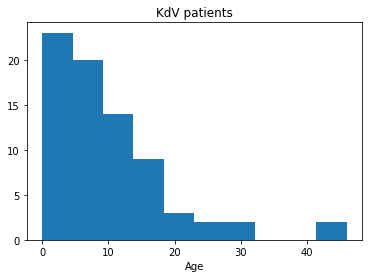

In [4]:
# Make a histogram of all ages

ages_kdv = df_kdv.age.values
print(len(ages_kdv))
plt.hist(ages_kdv)
plt.xlabel("Age")
plt.title("KdV patients")
plt.show()

In [5]:
# open ID control excel sheet
# location: H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\ID Controls\all_ID_controls_info_complete
ID_control_file = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\kdv_matched_ID_controls_info.xlsx"  # all_ID_controls_info_complete.xlsm"
if not os.path.exists(ID_control_file):
    print("This path does not exist.")
    
df_ID_control = pd.read_excel(ID_control_file)
# df_ID_control = df_ID_control[['pnummer', 'frontal face image', 'agecorrected', 'gender', 'etnicity']]
# df_ID_control = df_ID_control[df_ID_control['frontal face image'].notnull()]
# df_ID_control = df_ID_control.rename(columns={"frontal face image": "image", "agecorrected": "age"})
# print(df_ID_control.shape)
# print(df_ID_control.groupby(['etnicity']).count())

# df_ID_control = df_ID_control[df_ID_control['etnicity']=='eu']
print(df_ID_control.shape)
df_ID_control.sample(4)


(74, 6)


,Unnamed: 0,pnummer,image,age,gender,etnicity
15,259,P08-2230,P08-2230_F1_.JPG,15,f,eu
63,68,P04-1164,DSCN5787.JPG,6,m,eu
73,256,P08-1988,RIMG0594.JPG,6,f,eu
2,301,P09-0889,P09-0889_F1_.JPG,11,m,eu


In [6]:
# for each entry in KdV df find a matching ID control, save in new pandas dataframe

# empty object
df_selected_kdv = pd.DataFrame(columns=['pnummer', 'image', 'age', 'gender', 'etnicity'])
df_selected_ID = pd.DataFrame(columns=['pnummer', 'image', 'age', 'gender', 'etnicity'])

all_age_diff = []

for index, row in df_kdv.iterrows():
    # find comparable person in the ID_control file
    kdv_age = int(row['age'])
    
    # Age group of 2 - 13 
    if  lowest_age <= kdv_age <= highest_age:
        df_selected_kdv = df_selected_kdv.append(row)
        
        kdv_gender = row['gender'].lower()

        matched_ID_control = df_ID_control.loc[(df_ID_control['age'] == kdv_age) & (df_ID_control['gender'] == kdv_gender)]

        age_diff = [1, -1, 2, -2, 3, -3, 4, -4, 5, -5, 6, -6]
        i = 0
        while matched_ID_control.shape[0] == 0:
            matched_ID_control = df_ID_control.loc[(df_ID_control['age'] == kdv_age + age_diff[i]) & (df_ID_control['gender'] == kdv_gender)]
            i+= 1
            if i == len(age_diff):
                break

        if(matched_ID_control.shape[0] ==0):
            print("No match found within {} and {} years".format(max(age_diff), min(age_diff)))
            continue

        all_age_diff.append(age_diff[i])

        # pick a random control from this list to append to selected controls
        random_index = random.randint(0, matched_ID_control.shape[0]-1)
        selected_ID = matched_ID_control.iloc[random_index]
        df_selected_ID = df_selected_ID.append(selected_ID)

        # remove selected row 
        i = df_ID_control[(df_ID_control.image == selected_ID.image) & (df_ID_control.pnummer == selected_ID.pnummer)].index

        OG_shape = df_ID_control.shape
        df_ID_control = df_ID_control.drop(i)
        new_shape = df_ID_control.shape    

        if(OG_shape[0] - new_shape[0]> 1):
            print("Error")

In [7]:
print(df_selected_kdv.shape)
print(df_selected_ID.shape)

(19, 5)
(19, 6)


In [8]:
# save KdV data in a new Excel sheet 
# format: patient_ID_KdV - age - gender -ethnicity 
# location: H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien

df_selected_kdv.to_excel(r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\kdv_patients_info_age_group_" + str(lowest_age) + "_" + str(highest_age) + ".xlsx")


# save ID control data in a new Excel sheet 
# format: patient_ID_control - age - gender -ethnicity - 
df_selected_ID.to_excel(r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\kdv_matched_ID_controls_info_age_group_" + str(lowest_age) + "_" + str(highest_age) + ".xlsx")


### Open Excel files and write the found images to a new directory

In [9]:
ID_file = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\kdv_matched_ID_controls_info_age_group_" + str(lowest_age) + "_" + str(highest_age) + ".xlsx"
ID_directory = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\kdv-selected-ID-controls"
selected_ID_directory = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\kdv-selected-ID-controls-age-group-"+str(lowest_age) + "-" + str(highest_age)

# open excel file
df = pd.read_excel(ID_file)

for index,rows in df.iterrows():
    pnummer = rows['pnummer']
    image = rows['image']
    
    files = [f for f in listdir(ID_directory) if (isfile(join(ID_directory, f)) & ((pnummer + "_small_" + image.replace(".JPG", "") + "_crop_sized") in f))]
    if(len(files)==1):
        im = Image.open(join(ID_directory, files[0]))
        im.save(join(selected_ID_directory, files[0]))
    else: 
        print("Manually find image for " + str(pnummer) + "_small_" + str(image.replace(".JPG", "")) + "_crop_sized")   
        print("in " + str(ID_directory))


In [10]:
kdv_file = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\kdv_patients_info_age_group_"+ str(lowest_age) + "_" + str(highest_age) + ".xlsx"
kdv_directory = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\kdv-patients"
selected_kdv_directory = r"H:\Genetica Projecten\Facial Recognition\Studenten en Onderzoekers\Fien\kdv-patients-age-group-"+str(lowest_age) + "-" + str(highest_age)

df_kdv = pd.read_excel(kdv_file)

for index,rows in df_kdv.iterrows():
    image = rows['image']
    
    files = [f for f in listdir(kdv_directory) if (isfile(join(kdv_directory, f)) & ((image + "_crop_sized") in f))]
    if(len(files)==1):
        im = Image.open(join(kdv_directory, files[0]))
        im.save(join(selected_kdv_directory, files[0]))
    else: 
        print("Manually find image for image" + _crop_sized)